# Theft Data Analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import linregress

import gmaps

# Import API key
from api_keys import g_key

In [2]:
#define source data_set urls
o_theft_url = "../data_sets/o_theft_clean.csv"
v_theft_url = "../data_sets/v_theft_clean.csv"

In [3]:
# Read Ottawa and Vancouver file and store into Pandas data frame
o_theft_df = pd.read_csv(o_theft_url)
v_theft_df = pd.read_csv(v_theft_url)
o_theft_df["VOLUME"]= 1
v_theft_df["VOLUME"]= 1

o_theft_df

,Incident_StartDate,YEAR,MONTH,DAY,WEEKDAY,WEEK,X,Y,ONS_Neighbourhood_2019,LAT,LNG,VOLUME
0,2018-05-17,2018,5,17,Thursday,20,362989.6811,5015885.441,Old Barrhaven West,45.283108,-76.746999,1
1,2018-06-15,2018,6,15,Friday,24,363095.6819,5015986.442,Old Barrhaven West,45.284038,-76.745676,1
2,2018-09-20,2018,9,20,Thursday,38,362193.6729,5014083.423,Old Barrhaven West,45.266740,-76.756644,1
3,2019-05-06,2019,5,6,Monday,19,362524.6789,5016024.441,Old Barrhaven West,45.284268,-76.752964,1
4,2019-05-13,2019,5,13,Monday,20,362132.6740,5014518.427,Old Barrhaven West,45.270641,-76.757542,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3336,2019-06-18,2019,6,18,Tuesday,25,375194.7321,5032311.570,Greenbelt,45.433183,-76.595587,1
3337,2018-07-17,2018,7,17,Tuesday,29,364100.6819,5014888.478,Chapman Mills,45.274354,-76.732566,1
3338,2019-06-03,2019,6,3,Monday,23,366093.7041,5015071.682,Chapman Mills,45.276385,-76.707218,1
3339,2018-10-09,2018,10,9,Tuesday,41,369820.7101,5032646.585,Vanier South,45.435217,-76.664352,1


*******

# 1. Analysing Ottawa Data

### 1.1 - Data preperation and statistics

In [4]:
#grouping data per year and month
o_theft_group = o_theft_df.groupby(['YEAR', 'MONTH']).count()
o_theft_group.reset_index(inplace=True)

#adding a x-axis marker for data series plots
o_theft_group["YEAR"] = o_theft_group["YEAR"].astype(str)
o_theft_group["MONTH"] = o_theft_group["MONTH"].astype(str)

#o_theft_group['x'] = o_theft_group["YEAR"]+"-"+o_theft_group["MONTH"]
o_theft_group['Marker'] = o_theft_group[["YEAR", "MONTH"]].agg("-".join,axis = 1)

o_theft_group.head()


,YEAR,MONTH,Incident_StartDate,DAY,WEEKDAY,WEEK,X,Y,ONS_Neighbourhood_2019,LAT,LNG,VOLUME,Marker
0,2018,1,9,9,9,9,9,9,9,9,9,9,2018-1
1,2018,2,6,6,6,6,6,6,6,6,6,6,2018-2
2,2018,3,16,16,16,16,16,16,16,16,16,16,2018-3
3,2018,4,60,60,60,60,60,60,60,60,60,60,2018-4
4,2018,5,188,188,188,188,188,188,188,188,188,188,2018-5


In [5]:
#adding some statistics
o_theft_stat = o_theft_group.groupby(['YEAR']).agg({"VOLUME": ['sum','mean','median']})
o_theft_stat.reset_index(inplace=True)
o_theft_stat

YEAR VOLUME                   
           sum        mean median
0  2018   1204  100.333333   70.0
1  2019   1175   97.916667   80.5
2  2020    962   80.166667   72.5

### 1.2 - Overal trend analysis

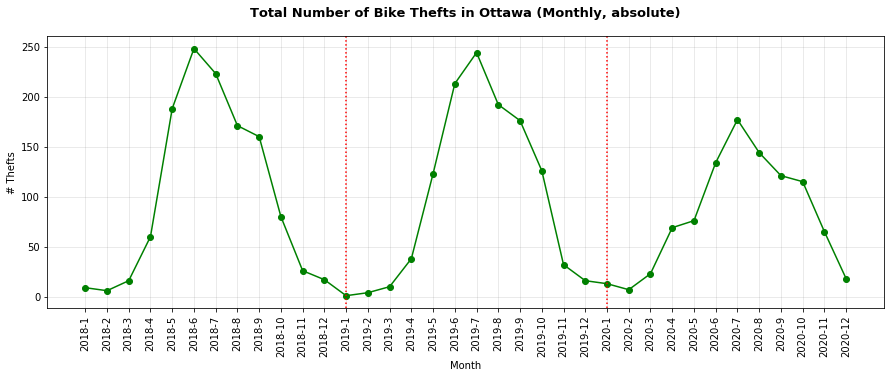

In [6]:
#ploting data series for Ottawa bike thefts (monthly)
plt.figure(figsize = (15,5))
plt.plot(o_theft_group["Marker"], o_theft_group["VOLUME"],color = "g", marker = "o")

plt.title(f"Total Number of Bike Thefts in Ottawa (Monthly, absolute)", fontsize = 13, fontweight = 'bold',y=1.05)
plt.xlabel("Month")
plt.xticks(rotation = 90)
plt.ylabel("# Thefts")
plt.grid(b=None, which='major', axis='both', color = "grey", alpha = 0.20)
plt.axvline(12, color = "red", linestyle = "dotted")
plt.axvline(24, color = "red", linestyle = "dotted")
plt.savefig("../analysis/ottawa_bike_thefts_month.png")
plt.show()

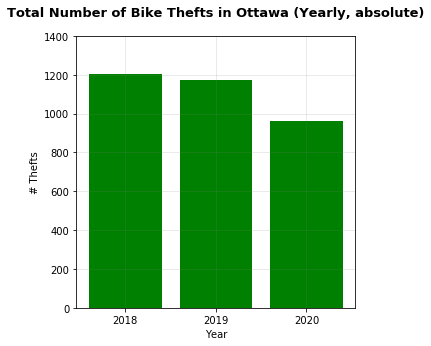

In [7]:
#ploting data series for Ottawa bike thefts (yearly)
plt.figure(figsize = (5,5))
plt.bar(o_theft_stat["YEAR"], o_theft_stat["VOLUME"]["sum"],color = "g")

plt.title(f"Total Number of Bike Thefts in Ottawa (Yearly, absolute)", fontsize = 13, fontweight = 'bold',y=1.05)
plt.xlabel("Year")
plt.xticks(rotation = 0)
plt.ylabel("# Thefts")
plt.grid(b=None, which='major', axis='both', color = "grey", alpha = 0.20)
plt.ylim(0,1400)
plt.savefig("../analysis/ottawa_bike_thefts_year.png")
plt.show()


ANALYSIS:
  * bike theft has a  cyclical trend, with most thefts happening in May through Sept
  * less thefts are observed in 2020 compared to 2018 and 2019

### 1.3 - Location analysis: heat map

In [8]:
#grouping by coordinates to plot the heatmap
o_coor_group = o_theft_df.groupby(['LAT', 'LNG']).count()
o_coor_group.reset_index(inplace=True)

#storing locaiton and humidity values for a heat map
location_df = o_coor_group[["LAT", "LNG"]]
o_theft_count_df = o_coor_group["VOLUME"]

o_coor_group

,LAT,LNG,Incident_StartDate,YEAR,MONTH,DAY,WEEKDAY,WEEK,X,Y,ONS_Neighbourhood_2019,VOLUME
0,45.057040,-76.746857,1,1,1,1,1,1,1,1,1,1
1,45.143071,-76.589813,1,1,1,1,1,1,1,1,1,1
2,45.150831,-76.591670,1,1,1,1,1,1,1,1,1,1
3,45.151062,-76.591244,1,1,1,1,1,1,1,1,1,1
4,45.154321,-76.584795,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1456,45.493688,-76.513684,1,1,1,1,1,1,1,1,1,1
1457,45.501724,-76.478852,1,1,1,1,1,1,1,1,1,1
1458,45.504940,-77.093024,1,1,1,1,1,1,1,1,1,1
1459,45.505660,-76.481502,1,1,1,1,1,1,1,1,1,1


In [9]:
# Access maps with unique API key
gmaps.configure(api_key=g_key)

In [10]:
#Plotting a heatmap of thefts 
centre_lat = o_coor_group['LAT'].mean()
centre_lng = o_coor_group['LNG'].mean()



figure_layout = {
   'width': '1300px',
    'height': '800px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout,center=(centre_lat, centre_lng), zoom_level=11)
heatmap = gmaps.heatmap_layer(location_df, weights=o_theft_count_df, point_radius = 10)
fig.add_layer(heatmap)

fig

Figure(layout=FigureLayout(border='1px solid black', height='800px', margin='0 auto 0 auto', padding='1px', wi…

### 1.4 - Daily trend analysis

##### Analysis of total bike thefts per weekday

    x creating new dataset to store the volume of bike thefts per week day for each year
    x ploting a relevant bar chart for each week day

In [11]:
#analysing weekdays thefts changes - total values

#gropping by weekdays and years
o_day_group = o_theft_df.groupby(['YEAR', 'WEEKDAY']).count()
o_day_group.reset_index(inplace=True)

#creating a new dataframe with years and weekdays 
o_day_group_18 = o_day_group.loc[o_day_group['YEAR']==2018,:]
o_day_group_19 = o_day_group.loc[o_day_group['YEAR']==2019,:]
o_day_group_20 = o_day_group.loc[o_day_group['YEAR']==2020,:]

o_day_group_18 = o_day_group_18[["WEEKDAY","VOLUME"]]
o_day_group_18 = o_day_group_18.rename(columns = {"VOLUME": "2018", "WEEKDAY":"YEAR"})
o_day_group_18.set_index("YEAR", inplace = True)
o_day_group_18 = o_day_group_18.transpose()

o_day_group_19 = o_day_group_19[["WEEKDAY","VOLUME"]]
o_day_group_19 = o_day_group_19.rename(columns = {"VOLUME": "2019", "WEEKDAY":"YEAR"})
o_day_group_19.set_index("YEAR", inplace = True)
o_day_group_19 = o_day_group_19.transpose()

o_day_group_20 = o_day_group_20[["WEEKDAY","VOLUME"]]
o_day_group_20 = o_day_group_20.rename(columns = {"VOLUME": "2020", "WEEKDAY":"YEAR"})
o_day_group_20.set_index("YEAR", inplace = True)
o_day_group_20 = o_day_group_20.transpose()

o_day_combined = o_day_group_18.append([o_day_group_19, o_day_group_20])
o_day_combined = o_day_combined[["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]]
o_day_combined



YEAR,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
2018,151,185,195,201,189,150,133
2019,195,187,203,153,177,121,139
2020,135,121,155,127,171,116,137


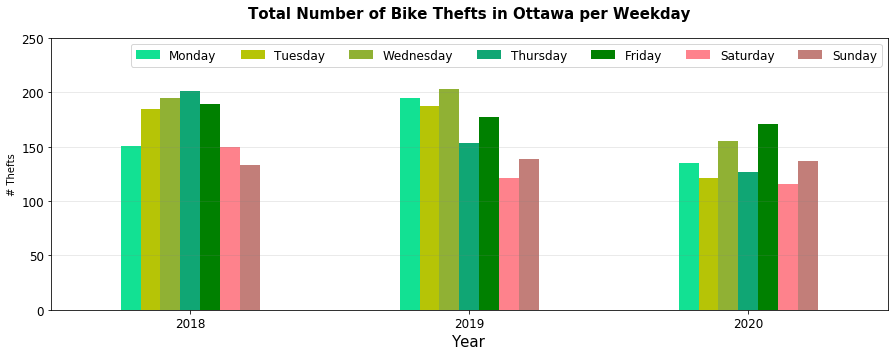

In [12]:
#ploting data series for Vancouver bike thefts (yearly)
color = ['#12e193', '#b6c406', '#90b134', '#10a674', '#008000',"#fe828c", "#c27e79"] #https://www.w3schools.com/colors/colors_xkcd.asp


multipl = o_day_combined.plot(kind = "bar", figsize = (15,5), color=color)

plt.title(f"Total Number of Bike Thefts in Ottawa per Weekday", fontsize = 15, fontweight = 'bold',y=1.05)
plt.xlabel("Year", fontsize = 15)
plt.xticks(rotation = 0, fontsize = 12)
plt.ylabel("# Thefts")
plt.yticks(fontsize = 12)
plt.ylim(0,250)
plt.legend(prop={'size': 12}, ncol = 7)
plt.grid(b=None, which='major', axis='y', color = "grey", alpha = 0.20)
plt.savefig("../analysis/ottawa_bike_thefts_day.png")
plt.show()



##### Analysis of average bike thefts per weekday

    x creating new dataset to group weekly thefts data and another dataset to store the average volume of bike thefts per week day for each year
    x ploting a relevant bar chart for each week day

In [13]:
#gropping by weekdays and years
o_week_group = o_theft_df.groupby(['YEAR','WEEKDAY','WEEK']).sum()
o_week_group.reset_index(inplace=True)
o_week_group

,YEAR,WEEKDAY,WEEK,MONTH,DAY,X,Y,LAT,LNG,VOLUME
0,2018,Friday,3,1,19,3.683305e+05,5.032411e+06,45.432816,-76.683333,1
1,2018,Friday,4,1,26,3.670627e+05,5.031220e+06,45.421858,-76.699213,1
2,2018,Friday,8,2,23,3.680517e+05,5.031033e+06,45.420363,-76.686527,1
3,2018,Friday,11,12,64,1.472772e+06,2.012667e+07,181.704426,-306.739550,4
4,2018,Friday,13,6,60,7.344998e+05,1.004217e+07,90.661389,-153.388109,2
...,...,...,...,...,...,...,...,...,...,...
764,2020,Wednesday,46,22,22,7.341154e+05,1.005444e+07,90.771653,-153.396346,2
765,2020,Wednesday,47,22,36,7.342429e+05,1.006192e+07,90.839088,-153.396784,2
766,2020,Wednesday,48,11,25,3.686372e+05,5.029141e+06,45.403457,-76.678541,1
767,2020,Wednesday,50,12,9,3.638484e+05,5.014984e+06,45.275168,-76.735808,1


In [14]:
#analysing weekdays thefts changes - average values

#gropping by weekdays and years
o_day_group_av = o_week_group.groupby(['YEAR','WEEKDAY']).mean()
o_day_group_av.reset_index(inplace=True)

#creating a new dataframe with years and weekdays 
o_day_group_av_18 = o_day_group_av.loc[o_day_group_av['YEAR']==2018,:]
o_day_group_av_19 = o_day_group_av.loc[o_day_group_av['YEAR']==2019,:]
o_day_group_av_20 = o_day_group_av.loc[o_day_group_av['YEAR']==2020,:]

o_day_group_av_18 = o_day_group_av_18[["WEEKDAY","VOLUME"]]
o_day_group_av_18 = o_day_group_av_18.rename(columns = {"VOLUME": "2018", "WEEKDAY":"YEAR"})
o_day_group_av_18.set_index("YEAR", inplace = True)
o_day_group_av_18 = o_day_group_av_18.transpose()

o_day_group_av_19 = o_day_group_av_19[["WEEKDAY","VOLUME"]]
o_day_group_av_19 = o_day_group_av_19.rename(columns = {"VOLUME": "2019", "WEEKDAY":"YEAR"})
o_day_group_av_19.set_index("YEAR", inplace = True)
o_day_group_av_19 = o_day_group_av_19.transpose()

o_day_group_av_20 = o_day_group_av_20[["WEEKDAY","VOLUME"]]
o_day_group_av_20 = o_day_group_av_20.rename(columns = {"VOLUME": "2020", "WEEKDAY":"YEAR"})
o_day_group_av_20.set_index("YEAR", inplace = True)
o_day_group_av_20 = o_day_group_av_20.transpose()

o_day_combined_av = o_day_group_av_18.append([o_day_group_av_19, o_day_group_av_20])
o_day_combined_av = o_day_combined_av[["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]]
o_day_combined_av

YEAR,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
2018,3.871795,5.000000,5.735294,5.02500,4.973684,5.000000,3.911765
2019,5.416667,5.054054,5.970588,4.50000,5.057143,4.172414,4.483871
2020,3.461538,3.270270,3.604651,3.25641,3.976744,2.900000,3.425000


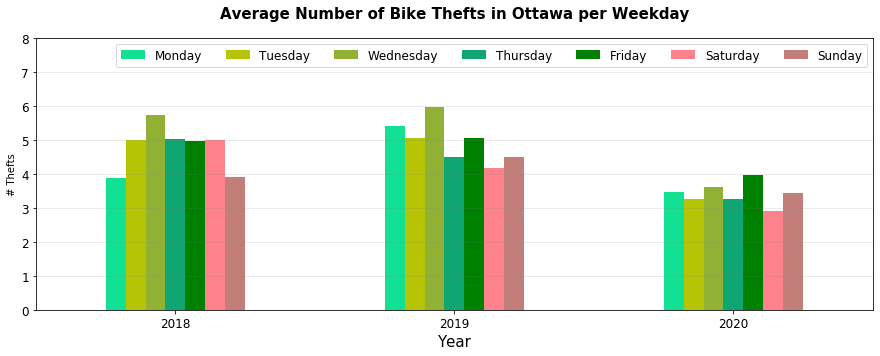

In [15]:
#ploting data series for Vancouver bike thefts (yearly)
color = ['#12e193', '#b6c406', '#90b134', '#10a674', '#008000',"#fe828c", "#c27e79"] #https://www.w3schools.com/colors/colors_xkcd.asp


multipl = o_day_combined_av.plot(kind = "bar", figsize = (15,5), color=color)

plt.title(f"Average Number of Bike Thefts in Ottawa per Weekday", fontsize = 15, fontweight = 'bold',y=1.05)
plt.xlabel("Year", fontsize = 15)
plt.xticks(rotation = 0, fontsize = 12)
plt.ylabel("# Thefts")
plt.yticks(fontsize = 12)
plt.ylim(0,8)
plt.legend(prop={'size': 12}, ncol = 7)
plt.grid(b=None, which='major', axis='y', color = "grey", alpha = 0.20)
plt.savefig("../analysis/ottawa_bike_thefts_av_day.png")
plt.show()



***********

## 2. Analysing Vancouver Data

### 2.1 - Data preperation and statistics

In [16]:
#grouping data per year and month
v_theft_group = v_theft_df.groupby(['YEAR', 'MONTH']).count()
v_theft_group.reset_index(inplace=True)

#adding a x-axis marker for data series plots
v_theft_group["YEAR"] = v_theft_group["YEAR"].astype(str)
v_theft_group["MONTH"] = v_theft_group["MONTH"].astype(str)
v_theft_group['Marker'] = v_theft_group[["YEAR", "MONTH"]].agg("-".join,axis = 1)

v_theft_group

,YEAR,MONTH,Incident_Date,DAY,WEEK,WEEKDAY,X,Y,LAT,LNG,VOLUME,Marker
0,2018,1,86,86,86,86,86,86,86,86,86,2018-1
1,2018,2,71,71,71,71,71,71,71,71,71,2018-2
2,2018,3,98,98,98,98,98,98,98,98,98,2018-3
3,2018,4,140,140,140,140,140,140,140,140,140,2018-4
4,2018,5,241,241,241,241,241,241,241,241,241,2018-5
5,2018,6,233,233,233,233,233,233,233,233,233,2018-6
6,2018,7,333,333,333,333,333,333,333,333,333,2018-7
7,2018,8,300,300,300,300,300,300,300,300,300,2018-8
8,2018,9,267,267,267,267,267,267,267,267,267,2018-9
9,2018,10,169,169,169,169,169,169,169,169,169,2018-10


In [17]:
#Adding some statistics
v_theft_stat = v_theft_group.groupby(['YEAR']).agg({"VOLUME": ['sum','mean','median']})
v_theft_stat.reset_index(inplace=True)
v_theft_stat

YEAR VOLUME                   
           sum        mean median
0  2018   2168  180.666667  154.5
1  2019   2219  184.916667  187.5
2  2020   1981  165.083333  159.5

### 2.2 - Overall trend analysis

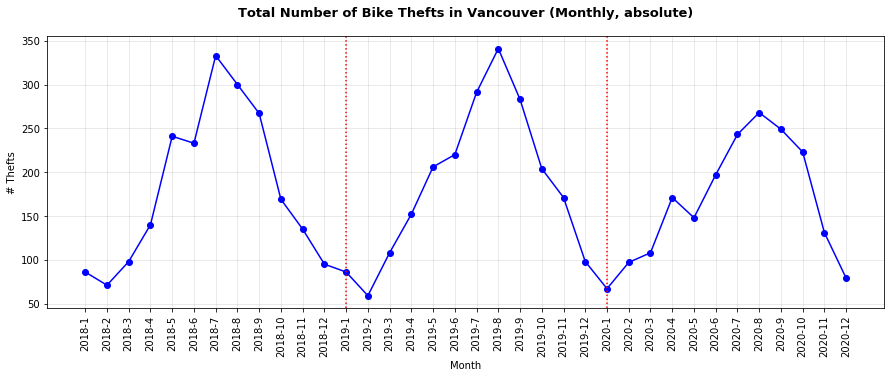

In [18]:
#ploting data series for Vancouver bike thefts
plt.figure(figsize = (15,5))
plt.plot(v_theft_group["Marker"], v_theft_group["VOLUME"],color = "b", marker = "o")

plt.title(f"Total Number of Bike Thefts in Vancouver (Monthly, absolute)", fontsize = 13, fontweight = 'bold',y=1.05)
plt.xlabel("Month")
plt.xticks(rotation = 90)
plt.ylabel("# Thefts")
plt.grid(b=None, which='major', axis='both', color = "grey", alpha = 0.20)
plt.axvline(12, color = "red", linestyle = "dotted")
plt.axvline(24, color = "red", linestyle = "dotted")
plt.savefig("../analysis/vancouv_bike_thefts_month.png")
plt.show()

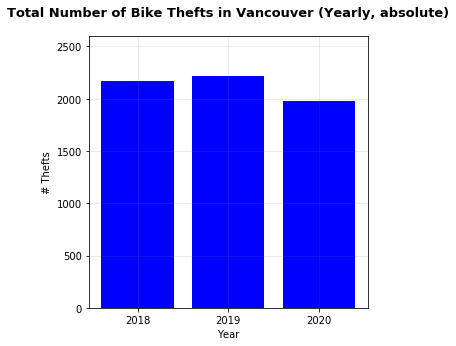

In [19]:
#ploting data series for Vancouver bike thefts (yearly)
plt.figure(figsize = (5,5))
plt.bar(v_theft_stat["YEAR"], v_theft_stat["VOLUME"]["sum"],color = "b")

plt.title(f"Total Number of Bike Thefts in Vancouver (Yearly, absolute)", fontsize = 13, fontweight = 'bold',y=1.05)
plt.xlabel("Year")
plt.xticks(rotation = 0)
plt.ylabel("# Thefts")
plt.grid(b=None, which='major', axis='both', color = "grey", alpha = 0.20)
plt.ylim(0,2600)
plt.savefig("../analysis/vancouv_bike_thefts_year.png")
plt.show()



### 2.3 - Location analysis: heat map

In [20]:
#grouping by coordinates to plot the heatmap
v_coor_group = v_theft_df.groupby(['LAT', 'LNG']).count()
v_coor_group.reset_index(inplace=True)

#storing locaiton and humidity values for a heat map
v_location_df = v_coor_group[["LAT", "LNG"]]
v_theft_count_df = v_coor_group["VOLUME"]

v_coor_group

,LAT,LNG,Incident_Date,YEAR,MONTH,DAY,WEEK,WEEKDAY,X,Y,VOLUME
0,49.204653,-123.025992,1,1,1,1,1,1,1,1,1
1,49.204661,-123.136219,1,1,1,1,1,1,1,1,1
2,49.205399,-123.037193,1,1,1,1,1,1,1,1,1
3,49.205641,-123.038888,1,1,1,1,1,1,1,1,1
4,49.205719,-123.038850,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
4700,49.300834,-123.130243,4,4,4,4,4,4,4,4,4
4701,49.301495,-123.156451,2,2,2,2,2,2,2,2,2
4702,49.301562,-123.156163,2,2,2,2,2,2,2,2,2
4703,49.302602,-123.129500,1,1,1,1,1,1,1,1,1


In [21]:
#Plotting a heatmap of thefts 

v_centre_lat = v_coor_group['LAT'].mean()
v_centre_lng = v_coor_group['LNG'].mean()

v_fig = gmaps.figure(center=(v_centre_lat, v_centre_lng), zoom_level=12)
v_heatmap = gmaps.heatmap_layer(v_location_df, weights=v_theft_count_df, point_radius = 10)
v_fig.add_layer(v_heatmap)

v_fig

Figure(layout=FigureLayout(height='420px'))

### 2.4 - Daily trend analysis

##### Analysis of total bike thefts per weekday


    x creating new dataset to store the volume of bike thefts per week day for each year
    x ploting a relevant bar chart for each week day

In [22]:
#analysing weekdays thefts changes

#gropping by weekdays and years
v_day_group = v_theft_df.groupby(['YEAR', 'WEEKDAY']).count()
v_day_group.reset_index(inplace=True)

#creating a new dataframe with years and weekdays 
v_day_group_18 = v_day_group.loc[v_day_group['YEAR']==2018,:]
v_day_group_19 = v_day_group.loc[v_day_group['YEAR']==2019,:]
v_day_group_20 = v_day_group.loc[v_day_group['YEAR']==2020,:]

v_day_group_18 = v_day_group_18[["WEEKDAY","VOLUME"]]
v_day_group_18 = v_day_group_18.rename(columns = {"VOLUME": "2018", "WEEKDAY":"YEAR"})
v_day_group_18.set_index("YEAR", inplace = True)
v_day_group_18 = v_day_group_18.transpose()

v_day_group_19 = v_day_group_19[["WEEKDAY","VOLUME"]]
v_day_group_19 = v_day_group_19.rename(columns = {"VOLUME": "2019", "WEEKDAY":"YEAR"})
v_day_group_19.set_index("YEAR", inplace = True)
v_day_group_19 = v_day_group_19.transpose()

v_day_group_20 = v_day_group_20[["WEEKDAY","VOLUME"]]
v_day_group_20 = v_day_group_20.rename(columns = {"VOLUME": "2020", "WEEKDAY":"YEAR"})
v_day_group_20.set_index("YEAR", inplace = True)
v_day_group_20 = v_day_group_20.transpose()

v_day_combined = v_day_group_18.append([v_day_group_19, v_day_group_20])
v_day_combined = v_day_combined[["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]]
v_day_combined


YEAR,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
2018,336,302,328,320,301,301,280
2019,313,345,265,337,341,320,298
2020,289,268,298,277,267,274,308


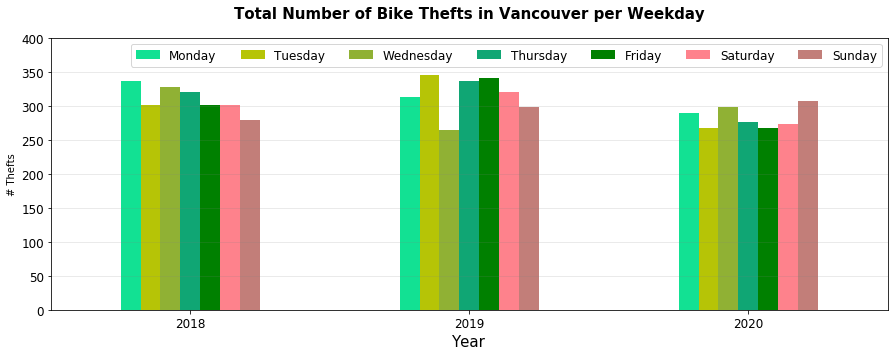

In [23]:
#ploting data series for Vancouver bike thefts (yearly)
color = color = ['#12e193', '#b6c406', '#90b134', '#10a674', '#008000',"#fe828c", "#c27e79"]


multipl = v_day_combined.plot(kind = "bar", figsize = (15,5), color=color)

plt.title(f"Total Number of Bike Thefts in Vancouver per Weekday", fontsize = 15, fontweight = 'bold',y=1.05)
plt.xlabel("Year", fontsize = 15)
plt.xticks(rotation = 0, fontsize = 12)
plt.ylabel("# Thefts")
plt.yticks(fontsize = 12)
plt.ylim(0,400)
plt.legend(prop={'size': 12}, ncol = 7)
plt.grid(b=None, which='major', axis='y', color = "grey", alpha = 0.20)
plt.savefig("../analysis/vancouv_bike_thefts_day.png")
plt.show()



##### Analysis of average bike thefts per weekday


    x creating new dataset to group weekly thefts data and another dataset to store the average volume of bike thefts per week day for each year
    x ploting a relevant bar chart for each week day

In [24]:
#gropping by weekdays and years
v_week_group = v_theft_df.groupby(['YEAR','WEEKDAY','WEEK']).sum()
v_week_group.reset_index(inplace=True)
v_week_group

,YEAR,WEEKDAY,WEEK,MONTH,DAY,X,Y,LAT,LNG,VOLUME
0,2018,Friday,1,2,10,9.852044e+05,1.091345e+07,98.526448,-246.203360,2
1,2018,Friday,2,4,48,1.963831e+06,2.182557e+07,197.040894,-492.497121,4
2,2018,Friday,3,2,38,9.838521e+05,1.091794e+07,98.566873,-246.222036,2
3,2018,Friday,4,4,104,1.965755e+06,2.183380e+07,197.114966,-492.470838,4
4,2018,Friday,5,14,14,3.446535e+06,3.820862e+07,344.946560,-861.735067,7
...,...,...,...,...,...,...,...,...,...,...
1059,2020,Wednesday,48,77,175,3.449105e+06,3.820520e+07,344.915749,-861.699676,7
1060,2020,Wednesday,49,24,4,9.881236e+05,1.091171e+07,98.510824,-246.163222,2
1061,2020,Wednesday,50,12,9,4.896390e+05,5.457358e+06,49.268892,-123.142423,1
1062,2020,Wednesday,52,36,69,1.474565e+06,1.636824e+07,147.772310,-369.349518,3


In [25]:
#analysing weekdays thefts changes - average values

#gropping by weekdays and years
v_day_group_av = v_week_group.groupby(['YEAR','WEEKDAY']).mean()
v_day_group_av.reset_index(inplace=True)

#creating a new dataframe with years and weekdays 
v_day_group_av_18 = v_day_group_av.loc[o_day_group_av['YEAR']==2018,:]
v_day_group_av_19 = v_day_group_av.loc[o_day_group_av['YEAR']==2019,:]
v_day_group_av_20 = v_day_group_av.loc[o_day_group_av['YEAR']==2020,:]

v_day_group_av_18 = v_day_group_av_18[["WEEKDAY","VOLUME"]]
v_day_group_av_18 = v_day_group_av_18.rename(columns = {"VOLUME": "2018", "WEEKDAY":"YEAR"})
v_day_group_av_18.set_index("YEAR", inplace = True)
v_day_group_av_18 = v_day_group_av_18.transpose()

v_day_group_av_19 = v_day_group_av_19[["WEEKDAY","VOLUME"]]
v_day_group_av_19 = v_day_group_av_19.rename(columns = {"VOLUME": "2019", "WEEKDAY":"YEAR"})
v_day_group_av_19.set_index("YEAR", inplace = True)
v_day_group_av_19 = v_day_group_av_19.transpose()

v_day_group_av_20 = v_day_group_av_20[["WEEKDAY","VOLUME"]]
v_day_group_av_20 = v_day_group_av_20.rename(columns = {"VOLUME": "2020", "WEEKDAY":"YEAR"})
v_day_group_av_20.set_index("YEAR", inplace = True)
v_day_group_av_20 = v_day_group_av_20.transpose()

v_day_combined_av = v_day_group_av_18.append([v_day_group_av_19, v_day_group_av_20])
v_day_combined_av = v_day_combined_av[["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]]
v_day_combined_av

YEAR,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
2018,6.588235,6.425532,6.307692,6.274510,6.020000,5.788462,5.384615
2019,6.137255,7.040816,5.300000,6.877551,6.557692,6.274510,5.960000
2020,5.557692,5.153846,5.730769,5.326923,5.448980,5.480000,6.160000


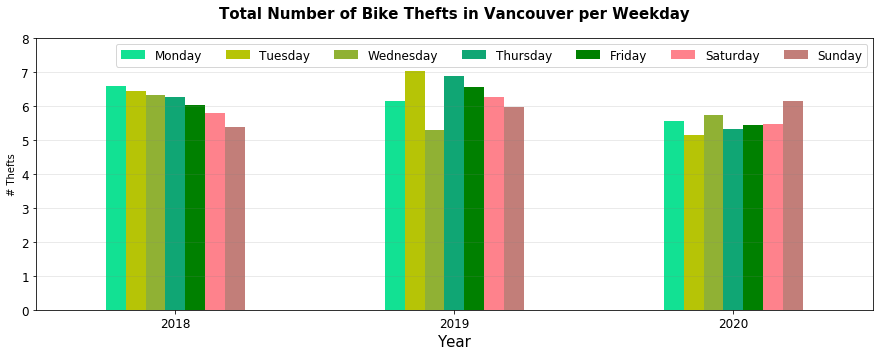

In [26]:
#ploting data series for Vancouver bike thefts (yearly)
color = color = ['#12e193', '#b6c406', '#90b134', '#10a674', '#008000',"#fe828c", "#c27e79"]


multipl = v_day_combined_av.plot(kind = "bar", figsize = (15,5), color=color)

plt.title(f"Total Number of Bike Thefts in Vancouver per Weekday", fontsize = 15, fontweight = 'bold',y=1.05)
plt.xlabel("Year", fontsize = 15)
plt.xticks(rotation = 0, fontsize = 12)
plt.ylabel("# Thefts")
plt.yticks(fontsize = 12)
plt.ylim(0,8)
plt.legend(prop={'size': 12}, ncol = 7)
plt.grid(b=None, which='major', axis='y', color = "grey", alpha = 0.20)
plt.savefig("../analysis/vancouv_bike_thefts_av_day.png")
plt.show()

***************************

# 3. Combined Analysis for two cities

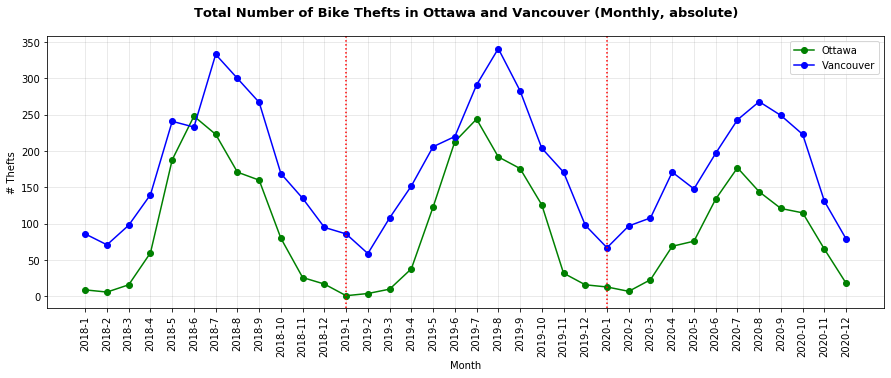

In [27]:
#ploting data series for bike thefts (monthly)
plt.figure(figsize = (15,5))
plt.plot(o_theft_group["Marker"], o_theft_group["VOLUME"],color = "g", marker = "o", label = "Ottawa")
plt.plot(v_theft_group["Marker"], v_theft_group["VOLUME"],color = "b", marker = "o", label = "Vancouver")

plt.title(f"Total Number of Bike Thefts in Ottawa and Vancouver (Monthly, absolute)", fontsize = 13, fontweight = 'bold',y=1.05)
plt.xlabel("Month")
plt.xticks(rotation = 90)
plt.ylabel("# Thefts")
plt.grid(b=None, which='major', axis='both', color = "grey", alpha = 0.20)
plt.axvline(12, color = "red", linestyle = "dotted")
plt.axvline(24, color = "red", linestyle = "dotted")
plt.legend(loc = "best")
plt.savefig("../analysis/combined_bike_thefts_month.png")
plt.show()

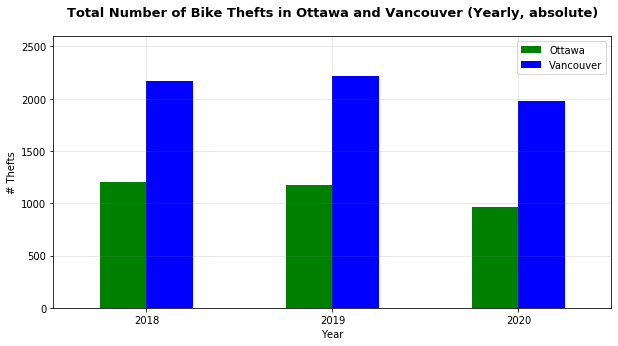

In [28]:
#ploting data series for bike thefts (yearly)
comb_df = pd.DataFrame(o_theft_stat["YEAR"])
comb_df["Ottawa"] = o_theft_stat["VOLUME"]["sum"]
comb_df["Vancouver"] = v_theft_stat["VOLUME"]["sum"]
multi_plot = comb_df.plot(kind = "bar", figsize = (10,5), color = ('g','b'))

multi_plot.set_xticklabels(comb_df["YEAR"])
plt.title(f"Total Number of Bike Thefts in Ottawa and Vancouver (Yearly, absolute)", fontsize = 13, fontweight = 'bold',y=1.05)
plt.xlabel("Year")
plt.xticks(rotation = 0)
plt.ylabel("# Thefts")
plt.grid(b=None, which='major', axis='both', color = "grey", alpha = 0.20)
plt.ylim(0,2600)
plt.savefig("../analysis/combined_bike_thefts_year.png")
plt.show()


need to do further anaysis of thefts per rides